Also, for zero weight decay and learning rate of 0.001, plot the training cross entropy (or
MSE) and accuracy curves for linear and logistic regression. For linear regression please
use the Adam optimizer instead of normal equations in this part.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

In [2]:
numTrainingSet    = 3500

# Load the Data
with np.load("notMNIST.npz") as data:
    Data, Target = data["images"], data["labels"]
    posClass = 2
    negClass = 9
    dataIndx = (Target==posClass) + (Target==negClass)
    Data = Data[dataIndx]/255.
    Target = Target[dataIndx].reshape(-1, 1)
    Target[Target==posClass] = 1
    Target[Target==negClass] = 0
    
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    
    Data, Target = Data[randIndx], Target[randIndx]
    Data = Data.reshape(-1, 28*28)
    trainData, trainTarget = Data[:3500], Target[:3500]
    validData, validTarget = Data[3500:3600], Target[3500:3600]
    testData, testTarget = Data[3600:], Target[3600:]

In [3]:
def classifyList(predList):
    classList = []
    for flt in predList:
        if (flt < 0.5):
            classList.append(0)
        else:
            classList.append(1)
    return classList

def calculateAccuracy(list1, list2):
    numCorrect = 0
    list1 = list1.reshape(-1)
    list2 = classifyList(list2)
    assert (len(list1) == len(list2))
    

    for idx in range(len(list1)):
        if (list1[idx] == list2[idx]):
            numCorrect += 1
        
    return (numCorrect/len(list1))

def buildGraph(wdCoef, learningRate):
    
    # Variable creation
    W = tf.Variable(tf.truncated_normal(shape=[28*28,1], stddev=0.5, name='weights'))
    b = tf.Variable(0.0, name='bias')
    X = tf.placeholder(tf.float32, [None, 28*28], name='input_x')
    y_target = tf.placeholder(tf.float32, [None, 1], name='target_y')

    # Graph definition
    y_predicted = tf.matmul(X, W) + b

    # Error definition
    MSELoss = tf.reduce_mean(tf.reduce_sum(tf.square(y_predicted - y_target), 
                                                   reduction_indices=1, 
                                                   name='mean_squared_error'),
                                     name='mean_square_error')
    WDLoss = wdCoef * tf.reduce_sum(tf.square(W))
    totalLoss = (MSELoss + WDLoss)/2
    
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learningRate)
    train = optimizer.minimize(loss=totalLoss)
    
    return X, y_target, y_predicted, MSELoss, WDLoss, totalLoss, train

def runIterations(weightDecayCoef, learningRate, batchSize, numIteration):
    numBatches        = int(numTrainingSet/batchSize)
    numEpoch          = int(math.ceil(numIteration/numBatches))
    
    X, y_target, y_predicted, MSELoss, WDLoss, totalLoss, train = buildGraph(weightDecayCoef, learningRate)
    
    # Initialize session    
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)

    # Train for numIteration amount
    iteration = 0
    lossMSE_list = []
    trainAccuracy_list = []
    for epochIdx in range(numEpoch):
        # Randomly permute the order of training examples
        randIdx = np.arange(numTrainingSet)
        np.random.shuffle(randIdx)

        # Mini-batching over entire dataset
        lossMSE, trainAccuracy = 0, 0
        yhat = []
        
        for batchIdx in range(numBatches):
            ridx_start = batchIdx * batchSize
            ridx_end = int(batchIdx+1) * batchSize

            _, lossMSE, lossTotal, yhat = sess.run([train, MSELoss, totalLoss, y_predicted],
                                                        feed_dict={X: trainData[randIdx[ridx_start:ridx_end],:],
                                                                   y_target: trainTarget[randIdx[ridx_start:ridx_end]]
                                                                  }
                                                       )
        
        
        yPred = sess.run(y_predicted, feed_dict={X: trainData, y_target:trainTarget})
        lossMSE_list.append(lossMSE)
        trainAccuracy_list.append(calculateAccuracy(trainTarget, yPred))
        
    return lossMSE_list, trainAccuracy_list

In [8]:
lossMSE_list, trainAccuracy_list = runIterations(0, 0.001, 500, 5000)

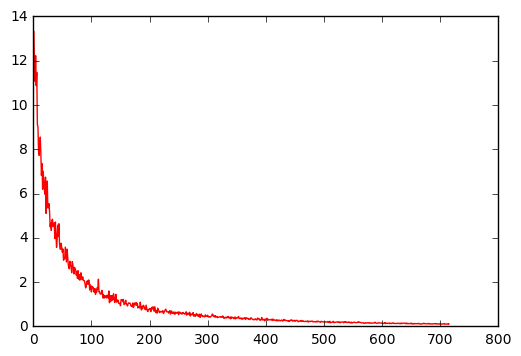

In [9]:
fig = plt.figure()
xRange = np.arange(1, len(lossMSE_list) + 1)
plt.plot(xRange, lossMSE_list, 'r-')
plt.show()


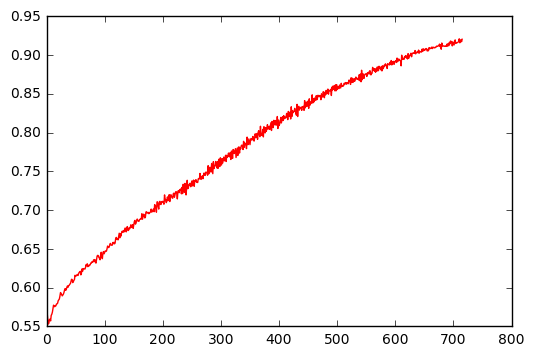

In [10]:
fig = plt.figure()
xRange = np.arange(1, len(lossMSE_list) + 1)
plt.plot(xRange, trainAccuracy_list, 'r-')
plt.show()


In [11]:
with np.load("notMNIST.npz") as data :
    Data, Target = data ["images"], data["labels"]
    posClass = 2
    negClass = 9
    dataIndx = (Target==posClass) + (Target==negClass)
    Data = Data[dataIndx]/255.
    Target = Target[dataIndx].reshape(-1, 1)
    Target[Target==posClass] = 1
    Target[Target==negClass] = 0
    np.random.seed(521)
    randIndx = np.arange(len(Data))
    np.random.shuffle(randIndx)
    Data, Target = Data[randIndx], Target[randIndx]
    trainData, trainTarget = Data[:3500], Target[:3500]
    validData, validTarget = Data[3500:3600], Target[3500:3600]
    testData, testTarget = Data[3600:], Target[3600:]

#flatten the 2D features to 1D
trainData=np.reshape(trainData, [3500, 28*28]) 
validData=np.reshape(validData, [100, 28*28]) 
testData=np.reshape(testData, [145, 28*28])


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.datasets import load_boston
from sklearn.preprocessing import scale

In [13]:
def logistic_regression_Adam(decay_lambda, iterations, mini_batch_size, learning_rate, num_classes):
    num_features=trainData.shape[1]
    
    X = tf.placeholder(dtype=tf.float64,shape=[None, num_features])
    Y = tf.placeholder(dtype=tf.int64,shape=[None, 1])
    
    W = tf.Variable(tf.zeros(dtype=tf.float64, shape=[num_features, num_classes]))
    b = tf.Variable(tf.zeros(dtype=tf.float64, shape=[num_classes]))
    
    #actual labels in one-hot vector form
    true_Y = tf.one_hot(Y, depth = num_classes)
    
    pred_Y = tf.matmul(X,W)+b
    
    Loss_D = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true_Y,logits=pred_Y))
    Loss_W = 0.5*decay_lambda*tf.reduce_sum(tf.square(W))
    total_loss = Loss_D + Loss_W
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
    train_set_size = trainData.shape[0]
    n_batch = train_set_size // mini_batch_size + (train_set_size % mini_batch_size != 0)
    init = tf.global_variables_initializer()
    
    #define an accuracy op for validation accuracy rate
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(Y), tf.argmax(pred_Y, axis=1)), tf.float64))
    
    with tf.Session() as sess:
        epoch_trace = []
        training_loss_trace = []
        training_accuracy_trace = []
        validation_loss_trace = []
        validation_accuracy_trace = []
        
        sess.run(init)
        
        for step in range(iterations):
            i_batch = (step%n_batch)*mini_batch_size
            xs = trainData[i_batch:i_batch+mini_batch_size]
            ys = trainTarget[i_batch:i_batch+mini_batch_size]
            
            Validation_Cost = sess.run(total_loss, feed_dict={X:validData, Y:validTarget})
            Validation_Accuracy = sess.run(accuracy, feed_dict={X:validData, Y:validTarget})
            
            Training_Cost = sess.run(total_loss, feed_dict={X:xs, Y:ys})
            Training_Accuracy = sess.run(accuracy, feed_dict={X:xs, Y:ys})
            
            sess.run(optimizer, feed_dict={X:xs, Y:ys})
            
            if(step%n_batch==0):
                epoch_number = step/n_batch
                epoch_trace.append(epoch_number)
                training_loss_trace.append(Training_Cost)
                training_accuracy_trace.append(Training_Accuracy)
                validation_loss_trace.append(Validation_Cost)
                validation_accuracy_trace.append(Validation_Accuracy)
                
    
        # Accuracy Rate for Validation Set
        output_str = "When weight decay coefficient = {}, " \
                     + "total iterations = {}, " \
                     + "mini_batch_size = {}, " \
                     + "learning rate = {}, " \
                     + "and total number of classes = {}:\n" \
                     + "the Accuracy Rate for Training Set is {:.6f} after training is finished.\n" \
                     + "The Accuracy Rate for Validation Set is {:.6f}.\n" \
                     + "The Accuracy Rate for Test Set is {:.6f}.\n" \
                     + "\n"
        train_accu = sess.run(accuracy, feed_dict={X:trainData, Y:trainTarget})
        valid_accu = sess.run(accuracy, feed_dict={X:validData, Y:validTarget})
        test_accu = sess.run(accuracy, feed_dict={X:testData, Y:testTarget})
        print(output_str.format(decay_lambda, iterations, mini_batch_size, learning_rate, \
              num_classes, train_accu, valid_accu, test_accu))
               
    return epoch_trace,training_loss_trace, training_accuracy_trace, \
            validation_loss_trace, validation_accuracy_trace

In [14]:
points7 = logistic_regression_Adam(decay_lambda=0, iterations=5000, mini_batch_size=500, learning_rate=0.001, num_classes=2)

When weight decay coefficient = 0, total iterations = 5000, mini_batch_size = 500, learning rate = 0.001, and total number of classes = 2:
the Accuracy Rate for Training Set is 0.998000 after training is finished.
The Accuracy Rate for Validation Set is 0.990000.
The Accuracy Rate for Test Set is 0.979310.




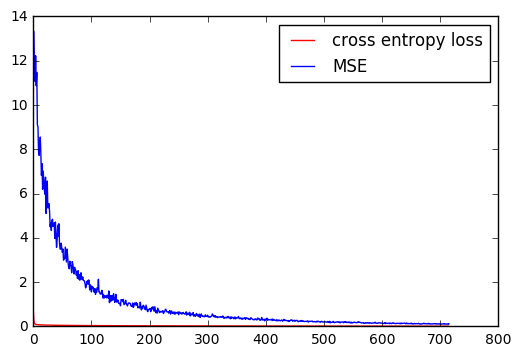

In [22]:
fig = plt.figure()

plt.plot(points7[0],points7[1],'r', label='cross entropy loss')

xRange = np.arange(1, len(lossMSE_list) + 1)
plt.plot(xRange, lossMSE_list, 'b', label='MSE')

plt.legend()
plt.show()

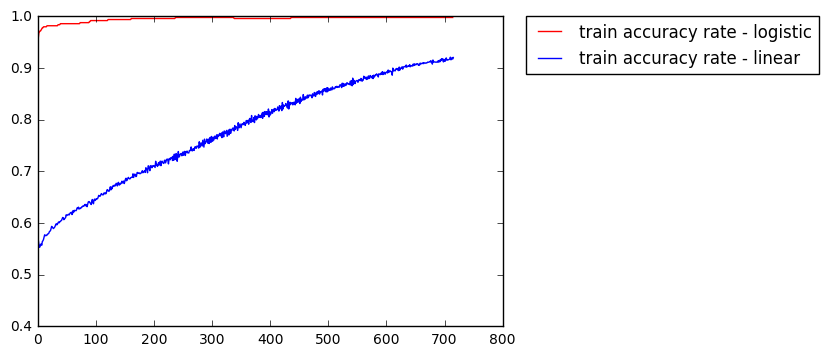

In [24]:
fig = plt.figure()
plt.plot(points7[0],points7[2],'r',label='train accuracy rate - logistic')

xRange = np.arange(1, len(lossMSE_list) + 1)
plt.plot(xRange, trainAccuracy_list, 'b',label='train accuracy rate - linear')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()